# بسم الله الرحمن الرحیم

در ابتدا هر کتاب خانه ای که نیاز بوده را منتقل کرده ام.

In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA,NMF
import matplotlib.pyplot as plt
from nltk import  stem, word_tokenize,download
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import pandasql as ps
from nltk import  stem, word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import codecs
import re

دو قسمت از کتابخانه ی پردازش زبان طبیعی ممکن است نیاز به دانلود داشته باشد

In [2]:
download('punkt')
download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arefghodamai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arefghodamai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

متن های داده شده را میخوانیم

In [3]:
subjects=['tech','sport','politics','entertainment','business']
news=pd.DataFrame(columns=['subject','text'])
n_samples=500
for i in range(1,n_samples):
    for sub in subjects:
        try:
            file_name='bbc-raw/'+sub+'/'+str(i).zfill(3)+'.txt'
            #print(file_name)
            text_file=open(file_name)
            n={'subject':sub,'text':text_file.read()}
            news=news.append(n, ignore_index=True )
        except:
            pass

In [4]:
news.head()

,subject,text
0,tech,Ink helps drive democracy in Asia\n\nThe Kyrgy...
1,sport,Claxton hunting first major medal\n\nBritish h...
2,politics,Labour plans maternity pay rise\n\nMaternity p...
3,entertainment,Gallery unveils interactive tree\n\nA Christma...
4,business,Ad sales boost Time Warner profit\n\nQuarterly...


حال نیاز به پیش پردازش داده ها داریم. ابتدا به کمک رجکس، چیزهایی از قبیل ایمیل، اسامی سایت و کاراکترهای نامربوط را حذف می کنیم. 
سپس به کمک کتابخانه ی

BeautifulSoup 

فرمت های اچ تی ام ال را حذف می کنیم،و با کمک ابزارهای پردازش زبان طبیعی، کلمات اضافه را حذف می کنیم.

In [5]:
compile_patterns = lambda patterns: [(re.compile(pattern), repl) for pattern, repl in patterns]

class PreprocessDescription(object):
    def __init__(self, lemmatizer_params, tokenizer_params):
        self.lemmatizer = stem.PorterStemmer(**lemmatizer_params)
        
        junk_chars_regex=r'[^a-zA-Z0-9\u0621-\u06CC\u0698\u067E\u0686\u06AF \u200c]'
        url_regex = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’]))"""
        RFC_5322_COMPLIANT_EMAIL_REGEX = r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
        
        remove_url=(url_regex, ' ')
        remove_email=(RFC_5322_COMPLIANT_EMAIL_REGEX, ' ')
        remove_junk_characters=(junk_chars_regex, ' ')
        self.compiled_patterns_before = compile_patterns([remove_url,remove_email])
        self.compiled_patterns_after = compile_patterns([remove_junk_characters])
        self.stopwords=set(stopwords.words('english'))
        
    def preprocess(self, text):
        # html parser
        soup = BeautifulSoup(text, 'html.parser')
        for br in soup.find_all("br"):
            br.replace_with("\n ")
        text = soup.getText()
        text = text.lower()
        for pattern, repl in self.compiled_patterns_before:
            text = pattern.sub(repl, text)
        text = re.sub(r'[\u200c\s]*\s[\s\u200c]*', ' ', text)
        text = re.sub(r'[\u200c]+', '\u200c', text)
        
        for pattern, repl in self.compiled_patterns_after:
            text = pattern.sub(repl, text)
            
        ## tokenized_words
        tokenized_words = word_tokenize(text)
        ## lemmatized_data
        lemmatized_words = [self.lemmatizer.stem(word) for word in tokenized_words]
        lemmatized_witout_stopwords = [word for word in lemmatized_words if word not in self.stopwords]
        return lemmatized_witout_stopwords

نمونه ای از کلمات اضافه:

In [6]:
stop=set(stopwords.words('english'))
print(stop)

{'your', 'when', 'it', "hadn't", 'very', 'we', 'y', 'themselves', 'only', 'them', 'i', 'of', 'under', 'there', 'hasn', 'yourself', 'over', 'or', 'should', 'myself', 'll', 'being', 'after', "you'd", 'his', 'what', 'so', 'm', 'here', 'not', 'will', "won't", 'some', 's', 'by', 'any', 'don', 'an', 'aren', "wouldn't", "haven't", 'do', 'in', 'off', 'wouldn', 'who', 'yours', 'which', 'other', 'didn', 'shouldn', 'is', 'did', "you're", 'having', 'between', "needn't", 'shan', 'their', 'down', "weren't", "you'll", 'was', "didn't", 'whom', 're', 'against', 'into', 'while', 'doing', 'isn', 'the', 've', 'has', 'to', 'doesn', "hasn't", 'he', 'couldn', 'they', "it's", 'haven', 'himself', 'our', 'can', 'nor', 'were', 'ourselves', 'herself', 'own', 'had', 'hadn', 'have', 'below', 'she', 'because', 'wasn', 'won', "couldn't", 'those', "wasn't", 'most', "mustn't", 'if', 'during', 'same', 'where', 'on', 'again', "don't", 'yourselves', 'ours', 'through', 'am', 'up', 'how', 'me', "that'll", 'why', 'these', 'd

In [7]:
preprocessDesc = PreprocessDescription(lemmatizer_params={},tokenizer_params={})

حال این پیش پردازش را برای تمامی متن های اخبار اجرا می کنیم و زمان لازم برای اجرا را اندازه گیری می کنیم.

In [8]:
import time
start = time.time()
preprocessed_text = []

for index, row in news.iterrows():
    res = preprocessDesc.preprocess(row['text'])
    preprocessed_text.append(" ".join(res))
    
news['preprocessed_text']=preprocessed_text
print(time.time() - start)

20.62487006187439


In [9]:
news.head()

,subject,text,preprocessed_text
0,tech,Ink helps drive democracy in Asia\n\nThe Kyrgy...,ink help drive democraci asia kyrgyz republ sm...
1,sport,Claxton hunting first major medal\n\nBritish h...,claxton hunt first major medal british hurdler...
2,politics,Labour plans maternity pay rise\n\nMaternity p...,labour plan matern pay rise matern pay new mot...
3,entertainment,Gallery unveils interactive tree\n\nA Christma...,galleri unveil interact tree christma tree rec...
4,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterli pro...


در ابتدا برای قدم اول، از الگوریتم

word2vec

برای بردارسازی کلمات استفاده می کنیم. تمامی کلمات موجود در متن های پیش پردازش شده را وارد الگوریتم یادگیری کرده سپس مجموع ی بردارهای یک مجموعه را به عنوان بردار شناسایی آن خبر انتخاب می کنیم.

In [11]:
DIMENSION = 100
words=[]
for index,row in news.iterrows():
    words.append(row['preprocessed_text'].split())


In [12]:
w2v_model = Word2Vec(words,sg=1,iter=10,size=DIMENSION)

In [13]:
news['w2v_vector'] = pd.Series(np.zeros((news.shape[0])), index=news.index)
b=[]

for index, row in news.iterrows():
    a=np.zeros(DIMENSION)
    for word in row['preprocessed_text'].split():
        try:
            a = a  + w2v_model.wv[word]
        except:
            pass
    b.append(a)

news['w2v_vector']=b
news.head()

,subject,text,preprocessed_text,w2v_vector
0,tech,Ink helps drive democracy in Asia\n\nThe Kyrgy...,ink help drive democraci asia kyrgyz republ sm...,"[54.53932825534139, -19.531038270502904, 50.36..."
1,sport,Claxton hunting first major medal\n\nBritish h...,claxton hunt first major medal british hurdler...,"[15.92768893763423, 5.133094194345176, 22.5778..."
2,politics,Labour plans maternity pay rise\n\nMaternity p...,labour plan matern pay rise matern pay new mot...,"[26.90462622232735, -3.0729057490825653, 21.88..."
3,entertainment,Gallery unveils interactive tree\n\nA Christma...,galleri unveil interact tree christma tree rec...,"[14.856102172401734, -18.65491425152868, 14.05..."
4,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterli pro...,"[24.80753529816866, -53.448007668950595, 0.989..."


برای نمایش این بردارهای ۱۰۰ بعدی نیز از الگوریتم

Principal Component Analysis 

استفاده می کنیم.

In [14]:
b_normal=normalize(b)
pca = PCA(n_components=2,whiten=True)
c_pca = pca.fit_transform(pd.DataFrame(b_normal))



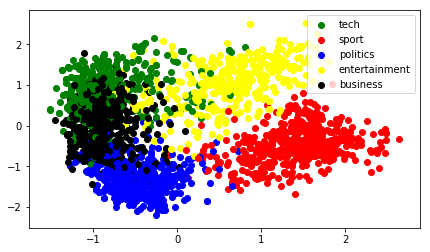

In [15]:
def show_original(news):
    fig,ax = plt.subplots(1,1,figsize=(7,4))
    for index, row in news.iterrows():
        if row['subject']=='sport':
            plt.scatter(c_pca[index][0],c_pca[index][1],color='red')
        elif row['subject']=='politics':
            plt.scatter(c_pca[index][0],c_pca[index][1],color='blue')
        elif row['subject']=='tech':
            plt.scatter(c_pca[index][0],c_pca[index][1],color='green')
        elif row['subject']=='entertainment':
            plt.scatter(c_pca[index][0],c_pca[index][1],color='yellow')
        elif row['subject']=='business':
            plt.scatter(c_pca[index][0],c_pca[index][1],color='black')
    plt.legend(['tech', 'sport', 'politics', 'entertainment', 'business'])
    plt.show()
show_original(news)


سپس قبل از دسته بندیِ، ابتدا به کمک اندازه گیری کوسینوس زاویه ی بین بردارهای معرف، سعی می کنیم نزدیک ترین بردارها را برای یک خبر خاص بیابیم

In [16]:
def get_w2v_top_similar_docs(data,text_vectors, index, k):
    data_res= data
    data_res['cosine'] = pd.Series(np.zeros(data_res.shape[0]), index=data_res.index)

    #package = data_res.loc[data_res['package_name']==package_name]
    comparing_vec = text_vectors[index]

    for index, row in data_res.iterrows():
        data_res.loc[index,'cosine']=(cosine_similarity(comparing_vec.reshape(1, -1),row['w2v_vector'].reshape(1, -1))[0])
#        pass-
    return data_res.nlargest(k, 'cosine')


پنج خبر نزدیک خبر شماره ی ۲ ورزشی را ملاحظه می فرمایید 

In [23]:
examples_df = get_w2v_top_similar_docs(news, b, index=1, k=5)
examples_df.head(10)

,subject,text,preprocessed_text,w2v_vector,cosine,label
1,sport,Claxton hunting first major medal\n\nBritish h...,claxton hunt first major medal british hurdler...,"[15.92768893763423, 5.133094194345176, 22.5778...",1.000000,2
316,sport,McIlroy continues winning streak\n\nJames McIl...,mcilroy continu win streak jame mcilroy storm ...,"[12.760075910482556, 9.095035489881411, 17.321...",0.982868,2
286,sport,Gardener battles to narrow win\n\nJason Garden...,garden battl narrow win jason garden fought wa...,"[85.30157310562208, 3.202141087385826, 75.2719...",0.981388,2
341,sport,Holmes back on form in Birmingham\n\nDouble Ol...,holm back form birmingham doubl olymp champion...,"[69.70367570122471, -10.267782974406146, 78.57...",0.977327,2
41,sport,Off-colour Gardener storms to win\n\nBritain's...,colour garden storm win britain jason garden s...,"[33.83314597187564, -5.540382070466876, 42.075...",0.977209,2


به کمک الگوریتم

KMeans

نیز یک خوشه بندی ۵ تایی برای این اخبار انجام می دهیم.

In [24]:
km = KMeans(n_clusters=5)
km.fit(b_normal)
#print(km.cluster_centers_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
def show_clustered(data,km):
    fig,ax = plt.subplots(1,1,figsize=(7,4))
    c=[]
    pca = PCA(n_components=2,whiten=True)
    for i in range(len(data)):
        #print(data[i])
        c.append(km.predict(data[i].reshape(1,-1))[0])

    X = pca.fit_transform(pd.DataFrame(data))
    #print(X.shape)
    for index in range(X.shape[0]):
        if c[index] ==0:
            plt.scatter(X[index][0],X[index][1],color='red')
        elif c[index] ==1:
            plt.scatter(X[index][0],X[index][1],color='blue')
        elif c[index] ==2:
            plt.scatter(X[index][0],X[index][1],color='green')
        elif c[index] ==3:
            plt.scatter(X[index][0],X[index][1],color='yellow')
        elif c[index] ==4:
            plt.scatter(X[index][0],X[index][1],color='black')
    plt.show()
    return c

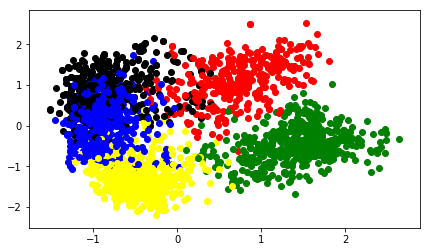

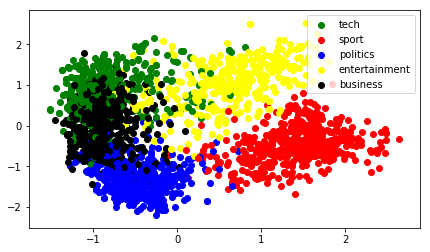

In [26]:
#print(b)
c=show_clustered(b_normal,km)
show_original(news)
news['label']=c[:]
#for i in range(len(c)):


In [27]:
news.head(10)

,subject,text,preprocessed_text,w2v_vector,cosine,label
0,tech,Ink helps drive democracy in Asia\n\nThe Kyrgy...,ink help drive democraci asia kyrgyz republ sm...,"[54.53932825534139, -19.531038270502904, 50.36...",0.756393,3
1,sport,Claxton hunting first major medal\n\nBritish h...,claxton hunt first major medal british hurdler...,"[15.92768893763423, 5.133094194345176, 22.5778...",1.000000,2
2,politics,Labour plans maternity pay rise\n\nMaternity p...,labour plan matern pay rise matern pay new mot...,"[26.90462622232735, -3.0729057490825653, 21.88...",0.797739,3
3,entertainment,Gallery unveils interactive tree\n\nA Christma...,galleri unveil interact tree christma tree rec...,"[14.856102172401734, -18.65491425152868, 14.05...",0.804295,0
4,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterli pro...,"[24.80753529816866, -53.448007668950595, 0.989...",0.782179,1
5,tech,China net cafe culture crackdown\n\nChinese au...,china net cafe cultur crackdown chines author ...,"[56.1191841205582, -35.452930002560606, 20.450...",0.716652,4
6,sport,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sullivan could run world sonia sullivan ha ind...,"[12.076606816612184, 1.6152534506982192, 20.54...",0.934918,2
7,politics,Watchdog probes e-mail deletions\n\nThe inform...,watchdog probe e mail delet inform commission ...,"[44.282609700225294, -21.09926699171774, 54.53...",0.693479,3
8,entertainment,Jarre joins fairytale celebration\n\nFrench mu...,jarr join fairytal celebr french musician jean...,"[21.564802825145307, -21.85225820937194, 32.53...",0.791389,0
9,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar ha hit hig...,"[-6.5020314826397225, -0.965555147617124, 0.35...",0.794180,1


In [22]:
query="""SELECT subject,label,count(*) c FROM news group by subject,label order by c DESC"""

print(ps.sqldf(query, locals()))


          subject  label    c
0           sport      2  494
1        business      1  461
2        politics      3  406
3            tech      0  383
4   entertainment      4  350
5        business      3   26
6   entertainment      0   16
7   entertainment      3   16
8        business      0   12
9        politics      1    7
10           tech      3    7
11           tech      4    6
12           tech      1    5
13  entertainment      1    4
14          sport      3    3
15       politics      0    2
16       politics      2    1
17       politics      4    1
18          sport      1    1
19          sport      4    1
